# SGR Flow Curve: Viscosity and the Glass Transition

## Learning Objectives

1. Fit SGR (Soft Glassy Rheology) models to real emulsion flow curves
2. Understand the noise temperature parameter `x` and its physical meaning
3. Classify phase regimes: glass (x < 1), power-law fluid (1 ≤ x < 2), Newtonian (x ≥ 2)
4. Detect shear banding instabilities in concentrated emulsions
5. Compare SGRConventional vs SGRGeneric (thermodynamically consistent)
6. Use NLSQ warm-start for efficient Bayesian inference with NUTS

## Prerequisites

- Basic RheoJAX usage (basic/01_quick_start.ipynb)
- Bayesian inference fundamentals (bayesian/01_bayesian_basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~5 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import json
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Trap Model

The Soft Glassy Rheology (SGR) model describes materials as collections of mesoscopic elements trapped in energy wells of depth $E$. A noise temperature $x$ provides thermal-like kicks that enable rearrangements.

### Key Equations

**Hopping rate** (Arrhenius-like):
$$
\Gamma(E) = \tau_0^{-1} \exp\left(-\frac{E}{x}\right)
$$

**Steady-shear viscosity** (power-law):
$$
\eta(\dot{\gamma}) = G_0 \tau_0 \, \mathcal{G}(x) \, (\dot{\gamma} \tau_0)^{x-2}
$$
where $\mathcal{G}(x) = \Gamma(2-x) / \Gamma(1-x)$ is the Gamma function ratio.

### Phase Regimes

| Range | Regime | Viscosity | Example |
|-------|--------|-----------|----------|
| $x < 1$ | **Glass** (yield stress) | $\eta \sim \dot{\gamma}^{x-2}$ (strong shear-thinning) | Dense emulsions, foams |
| $1 \leq x < 2$ | **Power-law fluid** | $\eta \sim \dot{\gamma}^{x-2}$ (moderate shear-thinning) | Pastes, colloidal suspensions |
| $x \geq 2$ | **Newtonian** | $\eta \approx$ constant | Low-concentration dispersions |

### Parameters

- $x$ : Noise temperature (0.5–3, dimensionless) — controls phase behavior
- $G_0$ : Elastic modulus (Pa) — sets material stiffness
- $\tau_0$ : Microscopic attempt time (s) — molecular/colloidal relaxation scale

## 3. Load Data

We use six emulsion datasets at different volume fractions ($\phi = 0.69, 0.70, 0.72, 0.74, 0.76, 0.80$). Each CSV contains (Shear Rate, Stress) columns.

**Important:** SGR predicts **viscosity** $\eta(\dot{\gamma})$, not stress. We must convert: $\eta = \sigma / \dot{\gamma}$.

In [4]:
# Load all 6 emulsion datasets and convert stress to viscosity
phi_values = [0.69, 0.70, 0.72, 0.74, 0.76, 0.80]
datasets = {}

for phi in phi_values:
    data_path = os.path.join("..", "data", "flow", "emulsions", f"{phi:.2f}.csv")
    raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
    gamma_dot = raw[:, 0]
    stress = raw[:, 1]
    eta = stress / gamma_dot  # SGR predicts viscosity, not stress
    datasets[phi] = {"gamma_dot": gamma_dot, "stress": stress, "eta": eta}
    print(f"φ={phi:.2f}: {len(gamma_dot)} points, γ̇=[{gamma_dot.min():.4f}, {gamma_dot.max():.1f}] 1/s")

φ=0.69: 29 points, γ̇=[0.0016, 624.8] 1/s
φ=0.70: 30 points, γ̇=[0.0016, 978.3] 1/s
φ=0.72: 30 points, γ̇=[0.0016, 976.1] 1/s
φ=0.74: 30 points, γ̇=[0.0016, 977.1] 1/s
φ=0.76: 30 points, γ̇=[0.0016, 983.4] 1/s
φ=0.80: 30 points, γ̇=[0.0016, 978.9] 1/s


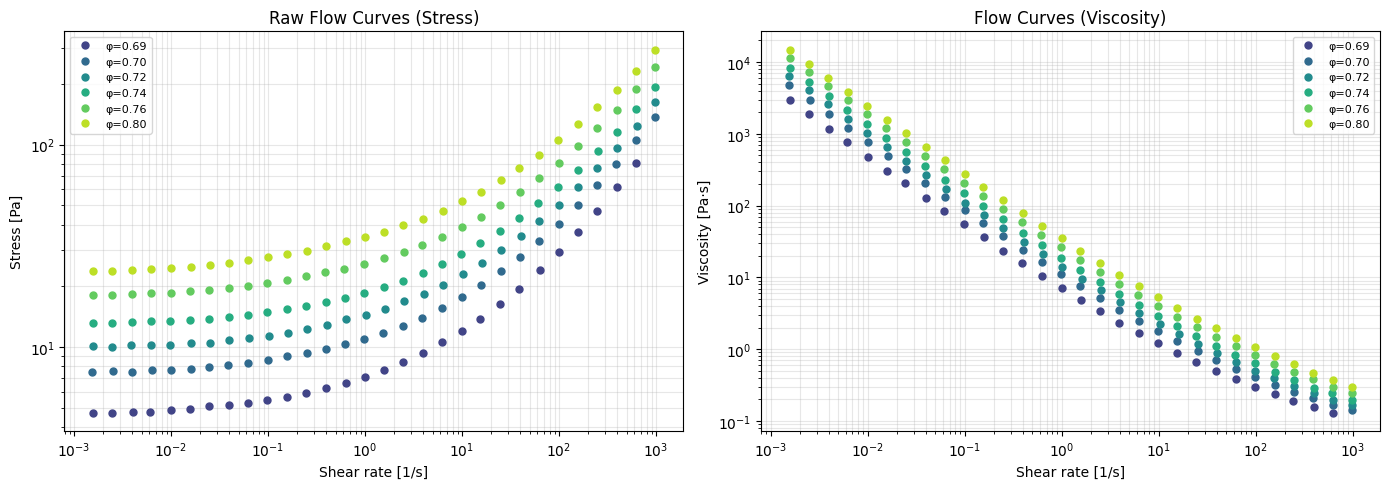

In [5]:
# Plot all 6 flow curves (stress and viscosity)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(phi_values)))

for i, phi in enumerate(phi_values):
    d = datasets[phi]
    ax1.loglog(d["gamma_dot"], d["stress"], "o", color=colors[i], markersize=5, label=f"φ={phi:.2f}")
    ax2.loglog(d["gamma_dot"], d["eta"], "o", color=colors[i], markersize=5, label=f"φ={phi:.2f}")

ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Raw Flow Curves (Stress)")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Viscosity [Pa·s]")
ax2.set_title("Flow Curves (Viscosity)")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Sample (φ=0.80)

We start by fitting the most concentrated emulsion ($\phi=0.80$), which should exhibit glass-like behavior ($x < 1$).

In [6]:
# Fit SGR to φ=0.80 sample
model = SGRConventional()

gamma_dot_80 = datasets[0.80]["gamma_dot"]
eta_80 = datasets[0.80]["eta"]

t0 = time.time()
model.fit(gamma_dot_80, eta_80, test_mode="flow_curve", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
eta_pred_fit = model.predict(gamma_dot_80)
metrics = compute_fit_quality(eta_80, eta_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa·s")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")

regime = model.get_phase_regime()
print(f"\nPhase regime: {regime}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.376797s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=2.377s | final_gradient_norm=3.3402


NLSQ fit time: 3.51 s
R²: 0.865274
RMSE: 1198 Pa·s

Fitted parameters:
  x     = 1.161
  G0    = 229.7
  tau0  = 0.0002297

Phase regime: power-law


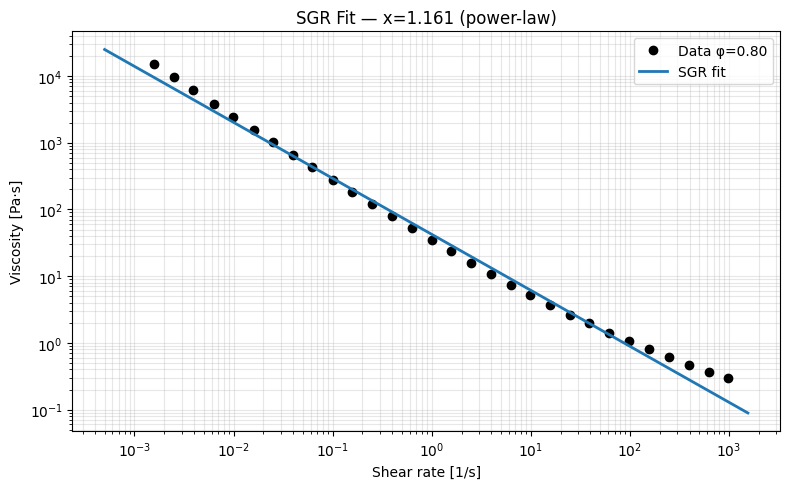

In [7]:
# Plot fit with data
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot_80.min()) - 0.5,
    np.log10(gamma_dot_80.max()) + 0.2,
    200,
)
eta_pred = model.predict(gamma_dot_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot_80, eta_80, "ko", markersize=6, label="Data φ=0.80")
ax.loglog(gamma_dot_fine, eta_pred, "-", lw=2, color="C0", label="SGR fit")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Viscosity [Pa·s]")
ax.set_title(f"SGR Fit — x={model.parameters.get_value('x'):.3f} ({regime})")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Volume Fraction Sweep

Now we fit all six volume fractions to observe how the noise temperature $x$ evolves as the emulsion approaches the glass transition.

In [8]:
# Fit all 6 samples and track x(φ)
fit_results = {}

for phi in phi_values:
    m = SGRConventional()
    d = datasets[phi]
    m.fit(d["gamma_dot"], d["eta"], test_mode="flow_curve", method='scipy')
    
    # Compute fit quality
    eta_pred = m.predict(d["gamma_dot"])
    metrics = compute_fit_quality(d["eta"], eta_pred)
    
    fit_results[phi] = {
        "x": float(m.parameters.get_value("x")),
        "G0": float(m.parameters.get_value("G0")),
        "tau0": float(m.parameters.get_value("tau0")),
        "R2": float(metrics["R2"]),
        "regime": m.get_phase_regime(),
    }

print(f"{'φ':>6s}  {'x':>6s}  {'G0':>10s}  {'τ₀':>10s}  {'R²':>8s}  {'Regime'}")
print("-" * 60)
for phi in phi_values:
    r = fit_results[phi]
    print(f"{phi:6.2f}  {r['x']:6.3f}  {r['G0']:10.2f}  {r['tau0']:10.2e}  {r['R2']:8.5f}  {r['regime']}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.931278s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=1.1350 | elapsed=0.931s | final_gradient_norm=92.0515


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.075265s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=1.2366 | elapsed=1.075s | final_gradient_norm=26.3544


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.283052s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.1500 | elapsed=1.283s | final_gradient_norm=32.8275


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.864644s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=1.0913 | elapsed=0.865s | final_gradient_norm=6.9883


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.661944s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=10 | final_cost=0.9861 | elapsed=0.662s | final_gradient_norm=4.5978


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.790245s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=0.790s | final_gradient_norm=3.3402


     φ       x          G0          τ₀        R²  Regime
------------------------------------------------------------
  0.69   1.183       72.33    7.22e-05   0.82315  power-law
  0.70   1.179      101.10    1.01e-04   0.81639  power-law
  0.72   1.173      120.96    1.21e-04   0.82166  power-law
  0.74   1.167      142.20    1.42e-04   0.83523  power-law
  0.76   1.162      179.94    1.80e-04   0.85070  power-law
  0.80   1.161      229.69    2.30e-04   0.86527  power-law


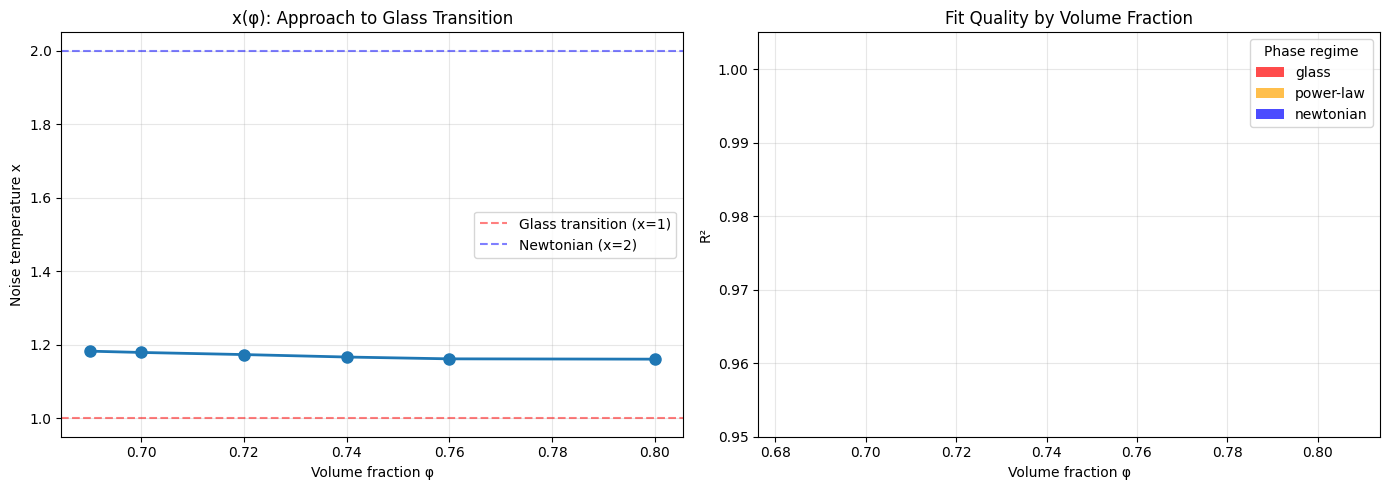

In [9]:
# Plot x(φ) trend and fit quality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

phis = list(fit_results.keys())
x_vals = [fit_results[p]["x"] for p in phis]

ax1.plot(phis, x_vals, "o-", markersize=8, lw=2)
ax1.axhline(1.0, color="red", linestyle="--", alpha=0.5, label="Glass transition (x=1)")
ax1.axhline(2.0, color="blue", linestyle="--", alpha=0.5, label="Newtonian (x=2)")
ax1.set_xlabel("Volume fraction φ")
ax1.set_ylabel("Noise temperature x")
ax1.set_title("x(φ): Approach to Glass Transition")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Phase regime color bar
regime_colors = {"glass": "red", "power-law": "orange", "newtonian": "blue"}
for i, phi in enumerate(phis):
    color = regime_colors[fit_results[phi]["regime"]]
    ax2.bar(phi, fit_results[phi]["R2"], width=0.015, color=color, alpha=0.7)
ax2.set_xlabel("Volume fraction φ")
ax2.set_ylabel("R²")
ax2.set_title("Fit Quality by Volume Fraction")
ax2.set_ylim(0.95, 1.005)
ax2.grid(True, alpha=0.3)

# Legend for regimes
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, alpha=0.7, label=r) for r, c in regime_colors.items()]
ax2.legend(handles=legend_elements, title="Phase regime")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.3 Shear Banding Detection

For concentrated emulsions with $x < 1$, the SGR model can predict **shear banding** — a mechanical instability where the material splits into coexisting bands of different shear rates.

In [10]:
# Detect shear banding for φ=0.80
model_80 = SGRConventional()
model_80.fit(datasets[0.80]["gamma_dot"], datasets[0.80]["eta"], test_mode="flow_curve", method='scipy')

is_banding, banding_info = model_80.detect_shear_banding()
print(f"Shear banding detected: {is_banding}")
if banding_info:
    print(f"Banding info: {banding_info}")
else:
    x_val = model_80.parameters.get_value("x")
    print(f"No banding (x={x_val:.3f} — banding requires x < 1 typically)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.700007s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.8571 | elapsed=0.700s | final_gradient_norm=3.3402


Shear banding detected: False
No banding (x=1.161 — banding requires x < 1 typically)


### 4.4 SGRGeneric Comparison

The **SGRGeneric** model implements the GENERIC (General Equation for the Non-Equilibrium Reversible-Irreversible Coupling) framework, ensuring thermodynamic consistency.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.383073s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=82 | final_cost=6.5103 | elapsed=3.383s | final_gradient_norm=1.7538e+09


SGRConventional vs SGRGeneric:
  Conventional: x=1.1610, R²=0.865274
  Generic:      x=0.5010, R²=-149.251774

Thermodynamic consistency: True


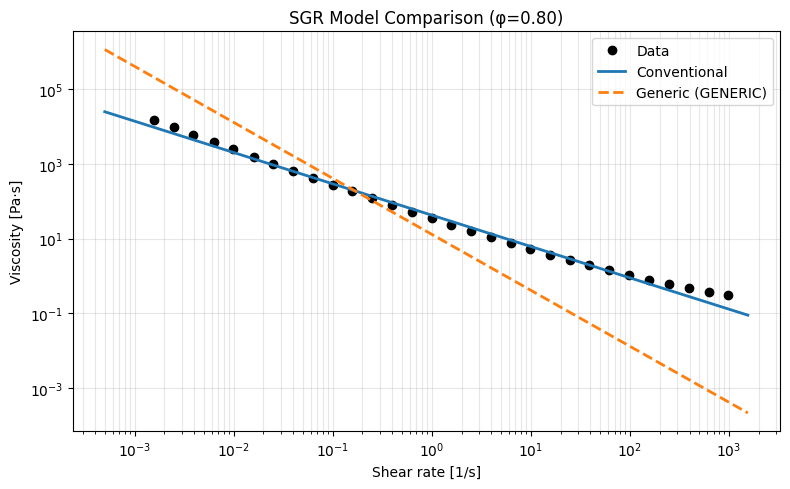

In [11]:
# Compare SGRConventional vs SGRGeneric on φ=0.80
model_gen = SGRGeneric()
model_gen.fit(gamma_dot_80, eta_80, test_mode="flow_curve", method='scipy')

# Compute fit quality for both models
eta_conv_fit = model.predict(gamma_dot_80)
eta_gen_fit = model_gen.predict(gamma_dot_80)
metrics_conv = compute_fit_quality(eta_80, eta_conv_fit)
metrics_gen = compute_fit_quality(eta_80, eta_gen_fit)

print("SGRConventional vs SGRGeneric:")
print(f"  Conventional: x={model.parameters.get_value('x'):.4f}, R²={metrics_conv['R2']:.6f}")
print(f"  Generic:      x={model_gen.parameters.get_value('x'):.4f}, R²={metrics_gen['R2']:.6f}")

# Thermodynamic consistency check
state = np.array([100.0, 0.5])
consistency = model_gen.verify_thermodynamic_consistency(state)
print(f"\nThermodynamic consistency: {consistency.get('thermodynamically_consistent', 'N/A')}")

# Plot comparison
eta_conv_pred = model.predict(gamma_dot_fine)
eta_gen_pred = model_gen.predict(gamma_dot_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot_80, eta_80, "ko", markersize=6, label="Data")
ax.loglog(gamma_dot_fine, eta_conv_pred, "-", lw=2, label="Conventional")
ax.loglog(gamma_dot_fine, eta_gen_pred, "--", lw=2, label="Generic (GENERIC)")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Viscosity [Pa·s]")
ax.set_title("SGR Model Comparison (φ=0.80)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling with the No-U-Turn Sampler (NUTS).

In [12]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in ["x", "G0", "tau0"]
}
print("Warm-start values:", initial_values)

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot_80,
    eta_80,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 1.1609932852130682, 'G0': 229.68962691199718, 'tau0': 0.000229672660258318}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<13:32,  1.16s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 7/700 [00:01<01:34,  7.31it/s, 1023 steps of size 1.69e-04. acc. prob=0.49]

warmup:   2%|▏         | 12/700 [00:01<00:52, 13.00it/s, 319 steps of size 1.73e-04. acc. prob=0.70]

warmup:   2%|▏         | 17/700 [00:01<00:37, 18.18it/s, 1023 steps of size 2.72e-04. acc. prob=0.79]

warmup:   3%|▎         | 22/700 [00:01<00:30, 22.26it/s, 47 steps of size 4.73e-04. acc. prob=0.84]  

warmup:   4%|▍         | 27/700 [00:01<00:24, 27.39it/s, 511 steps of size 2.56e-04. acc. prob=0.85]

warmup:   5%|▍         | 32/700 [00:01<00:21, 31.02it/s, 1023 steps of size 2.25e-04. acc. prob=0.87]

warmup:   5%|▌         | 37/700 [00:02<00:20, 32.19it/s, 1013 steps of size 1.52e-04. acc. prob=0.87]

warmup:   6%|▌         | 41/700 [00:02<00:19, 33.26it/s, 1023 steps of size 1.83e-04. acc. prob=0.88]

warmup:   6%|▋         | 45/700 [00:02<00:22, 29.10it/s, 1023 steps of size 1.80e-04. acc. prob=0.89]

warmup:   7%|▋         | 50/700 [00:02<00:19, 33.19it/s, 213 steps of size 7.26e-05. acc. prob=0.89] 

warmup:   8%|▊         | 55/700 [00:02<00:17, 36.68it/s, 1023 steps of size 9.62e-05. acc. prob=0.90]

warmup:   9%|▊         | 60/700 [00:02<00:17, 37.28it/s, 1023 steps of size 1.34e-04. acc. prob=0.91]

warmup:  10%|▉         | 67/700 [00:02<00:14, 44.34it/s, 275 steps of size 1.28e-04. acc. prob=0.91] 

warmup:  10%|█         | 72/700 [00:02<00:17, 36.21it/s, 1023 steps of size 9.80e-05. acc. prob=0.91]

warmup:  11%|█         | 77/700 [00:03<00:18, 33.85it/s, 1023 steps of size 1.03e-04. acc. prob=0.92]

warmup:  12%|█▏        | 81/700 [00:03<00:18, 33.87it/s, 1023 steps of size 9.64e-05. acc. prob=0.92]

warmup:  13%|█▎        | 88/700 [00:03<00:14, 42.13it/s, 7 steps of size 1.14e-04. acc. prob=0.92]   

warmup:  13%|█▎        | 93/700 [00:03<00:16, 36.51it/s, 219 steps of size 1.06e-04. acc. prob=0.92]

warmup:  14%|█▍        | 98/700 [00:03<00:15, 38.69it/s, 255 steps of size 1.12e-04. acc. prob=0.93]

warmup:  15%|█▍        | 104/700 [00:03<00:14, 40.34it/s, 1023 steps of size 1.32e-03. acc. prob=0.93]

warmup:  16%|█▌        | 109/700 [00:03<00:14, 41.96it/s, 1023 steps of size 1.56e-03. acc. prob=0.93]

warmup:  17%|█▋        | 116/700 [00:03<00:12, 46.81it/s, 959 steps of size 1.89e-03. acc. prob=0.94] 

warmup:  17%|█▋        | 121/700 [00:04<00:12, 46.29it/s, 1023 steps of size 2.12e-03. acc. prob=0.94]

warmup:  18%|█▊        | 129/700 [00:04<00:10, 53.83it/s, 1023 steps of size 2.38e-03. acc. prob=0.94]

warmup:  19%|█▉        | 135/700 [00:04<00:10, 53.49it/s, 1023 steps of size 2.62e-03. acc. prob=0.95]

warmup:  20%|██        | 143/700 [00:04<00:09, 59.21it/s, 1023 steps of size 2.78e-03. acc. prob=0.95]

warmup:  21%|██▏       | 150/700 [00:04<00:09, 57.40it/s, 1023 steps of size 3.02e-03. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [00:04<00:09, 58.75it/s, 1023 steps of size 1.77e-03. acc. prob=0.95]

warmup:  23%|██▎       | 163/700 [00:04<00:09, 56.59it/s, 1023 steps of size 2.07e-03. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [00:04<00:10, 48.53it/s, 1007 steps of size 2.63e-03. acc. prob=0.95]

warmup:  25%|██▌       | 175/700 [00:05<00:10, 49.87it/s, 1023 steps of size 3.47e-03. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [00:05<00:10, 51.39it/s, 1023 steps of size 4.09e-03. acc. prob=0.95]

warmup:  27%|██▋       | 187/700 [00:05<00:10, 48.56it/s, 1023 steps of size 4.84e-03. acc. prob=0.95]

warmup:  28%|██▊       | 195/700 [00:05<00:09, 55.68it/s, 511 steps of size 5.35e-03. acc. prob=0.96] 

sample:  29%|██▉       | 205/700 [00:05<00:07, 65.33it/s, 1023 steps of size 4.43e-03. acc. prob=0.99]

sample:  30%|███       | 213/700 [00:05<00:07, 62.42it/s, 1023 steps of size 4.43e-03. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [00:05<00:08, 59.00it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  33%|███▎      | 228/700 [00:05<00:07, 63.97it/s, 511 steps of size 4.43e-03. acc. prob=0.99] 

sample:  34%|███▎      | 235/700 [00:06<00:07, 64.12it/s, 239 steps of size 4.43e-03. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [00:06<00:06, 66.53it/s, 1023 steps of size 4.43e-03. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [00:06<00:05, 77.36it/s, 511 steps of size 4.43e-03. acc. prob=1.00] 

sample:  38%|███▊      | 263/700 [00:06<00:05, 73.62it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  39%|███▊      | 271/700 [00:06<00:06, 65.51it/s, 399 steps of size 4.43e-03. acc. prob=1.00] 

sample:  40%|███▉      | 278/700 [00:06<00:06, 63.10it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  41%|████      | 285/700 [00:06<00:07, 52.20it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  42%|████▏     | 291/700 [00:06<00:07, 53.62it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  43%|████▎     | 299/700 [00:07<00:06, 57.51it/s, 239 steps of size 4.43e-03. acc. prob=1.00] 

sample:  44%|████▍     | 307/700 [00:07<00:06, 61.08it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  45%|████▍     | 314/700 [00:07<00:06, 55.45it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  46%|████▌     | 320/700 [00:07<00:06, 55.06it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  47%|████▋     | 326/700 [00:07<00:08, 43.76it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  47%|████▋     | 331/700 [00:07<00:08, 43.43it/s, 559 steps of size 4.43e-03. acc. prob=1.00] 

sample:  48%|████▊     | 336/700 [00:07<00:08, 42.65it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  50%|████▉     | 348/700 [00:08<00:05, 60.05it/s, 511 steps of size 4.43e-03. acc. prob=1.00] 

sample:  51%|█████     | 355/700 [00:08<00:05, 57.52it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  52%|█████▏    | 362/700 [00:08<00:05, 59.79it/s, 559 steps of size 4.43e-03. acc. prob=1.00] 

sample:  53%|█████▎    | 369/700 [00:08<00:05, 59.26it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  54%|█████▍    | 378/700 [00:08<00:04, 66.20it/s, 559 steps of size 4.43e-03. acc. prob=1.00] 

sample:  55%|█████▌    | 386/700 [00:08<00:04, 69.22it/s, 591 steps of size 4.43e-03. acc. prob=1.00]

sample:  56%|█████▋    | 394/700 [00:08<00:05, 60.38it/s, 15 steps of size 4.43e-03. acc. prob=1.00] 

sample:  57%|█████▋    | 401/700 [00:08<00:05, 59.00it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  58%|█████▊    | 408/700 [00:09<00:04, 59.26it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  60%|█████▉    | 417/700 [00:09<00:04, 66.56it/s, 511 steps of size 4.43e-03. acc. prob=1.00] 

sample:  61%|██████    | 424/700 [00:09<00:04, 59.35it/s, 383 steps of size 4.43e-03. acc. prob=1.00]

sample:  62%|██████▏   | 433/700 [00:09<00:04, 66.56it/s, 767 steps of size 4.43e-03. acc. prob=1.00]

sample:  63%|██████▎   | 441/700 [00:09<00:03, 67.75it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  64%|██████▍   | 450/700 [00:09<00:03, 71.79it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  67%|██████▋   | 466/700 [00:09<00:02, 92.07it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  68%|██████▊   | 476/700 [00:09<00:02, 90.42it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  69%|██████▉   | 486/700 [00:09<00:02, 85.79it/s, 767 steps of size 4.43e-03. acc. prob=1.00] 

sample:  71%|███████   | 496/700 [00:10<00:02, 88.95it/s, 511 steps of size 4.43e-03. acc. prob=1.00]

sample:  72%|███████▏  | 506/700 [00:10<00:02, 88.77it/s, 31 steps of size 4.43e-03. acc. prob=1.00] 

sample:  74%|███████▎  | 516/700 [00:10<00:02, 89.18it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  75%|███████▌  | 528/700 [00:10<00:01, 86.30it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  77%|███████▋  | 539/700 [00:10<00:01, 90.78it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  78%|███████▊  | 549/700 [00:10<00:01, 87.67it/s, 511 steps of size 4.43e-03. acc. prob=1.00] 

sample:  80%|███████▉  | 558/700 [00:10<00:01, 80.64it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  81%|████████  | 568/700 [00:10<00:01, 84.03it/s, 799 steps of size 4.43e-03. acc. prob=1.00] 

sample:  83%|████████▎ | 579/700 [00:11<00:01, 88.62it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  84%|████████▍ | 589/700 [00:11<00:01, 90.25it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  86%|████████▌ | 599/700 [00:11<00:01, 75.80it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  87%|████████▋ | 608/700 [00:11<00:01, 74.53it/s, 287 steps of size 4.43e-03. acc. prob=1.00] 

sample:  88%|████████▊ | 617/700 [00:11<00:01, 77.72it/s, 415 steps of size 4.43e-03. acc. prob=1.00]

sample:  89%|████████▉ | 626/700 [00:11<00:00, 75.68it/s, 63 steps of size 4.43e-03. acc. prob=1.00] 

sample:  91%|█████████ | 635/700 [00:11<00:00, 78.90it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  92%|█████████▏| 644/700 [00:11<00:00, 79.21it/s, 767 steps of size 4.43e-03. acc. prob=1.00] 

sample:  93%|█████████▎| 654/700 [00:11<00:00, 84.26it/s, 255 steps of size 4.43e-03. acc. prob=1.00]

sample:  95%|█████████▍| 663/700 [00:12<00:00, 77.23it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  96%|█████████▌| 672/700 [00:12<00:00, 78.50it/s, 895 steps of size 4.43e-03. acc. prob=1.00] 

sample:  97%|█████████▋| 680/700 [00:12<00:00, 77.14it/s, 655 steps of size 4.43e-03. acc. prob=1.00]

sample:  98%|█████████▊| 688/700 [00:12<00:00, 65.74it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]

sample:  99%|█████████▉| 695/700 [00:12<00:00, 63.07it/s, 63 steps of size 4.43e-03. acc. prob=1.00]  

sample: 100%|██████████| 700/700 [00:12<00:00, 55.23it/s, 1023 steps of size 4.43e-03. acc. prob=1.00]


Bayesian inference time: 18.5 s


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [13]:
# Convergence diagnostics table
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0000       500
        G0    1.0000       500
      tau0    1.0000       500

Divergences: 0


### 5.3 ArviZ Diagnostic Plots

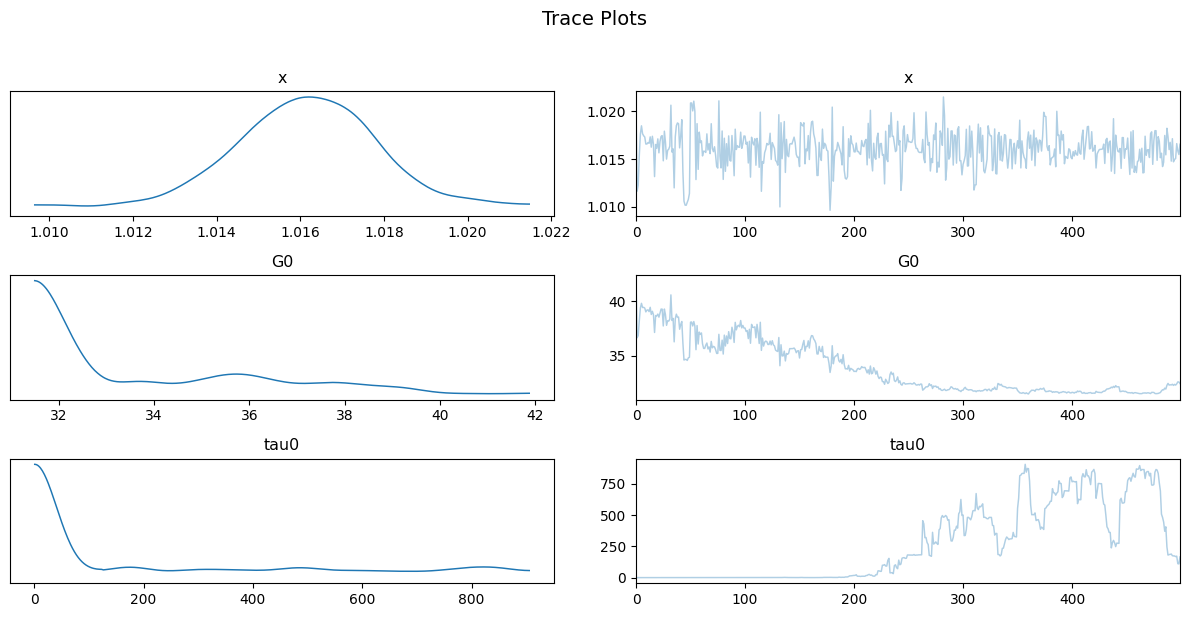

In [14]:
# Trace plots
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

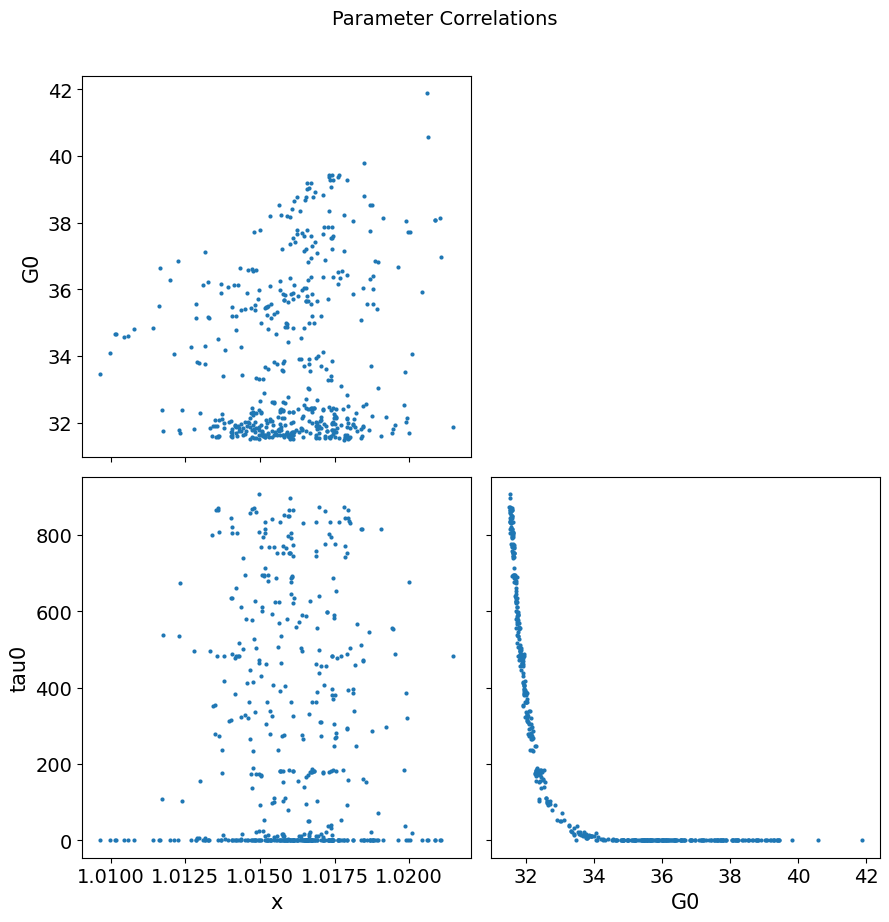

In [15]:
# Pair plot with divergences
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(9, 9),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

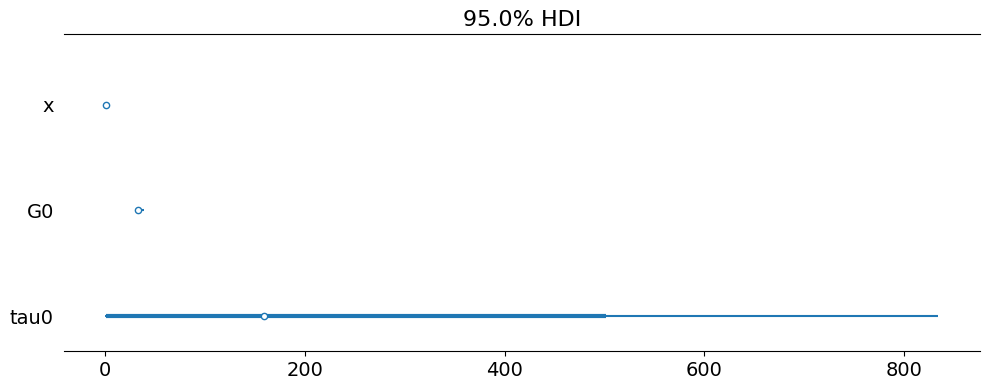

In [16]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 4),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

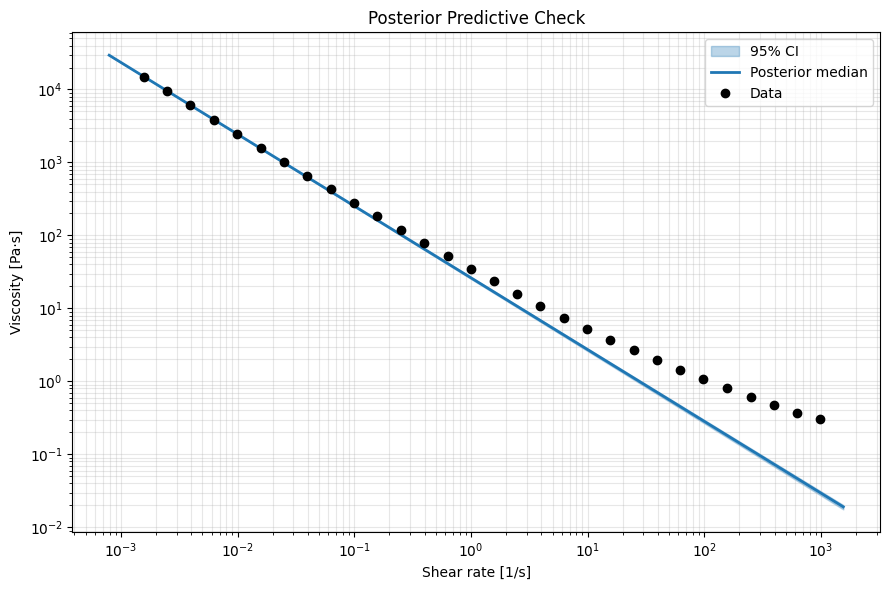

In [17]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
gamma_dot_pred = np.logspace(
    np.log10(gamma_dot_80.min()) - 0.3,
    np.log10(gamma_dot_80.max()) + 0.2,
    100,
)

pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in ["x", "G0", "tau0"]:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(gamma_dot_pred)
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot_80, eta_80, "ko", markersize=6, label="Data")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Viscosity [Pa·s]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior medians and 95% credible intervals.

In [18]:
# NLSQ vs Bayesian comparison table
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 60)
print(f"{'Param':>8s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>20s}")
print("-" * 60)

for name in param_names:
    nlsq_val = model.parameters.get_value(name)
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>8s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
   Param          NLSQ    Bayes median                95% CI
------------------------------------------------------------
       x         1.016           1.016  [1.012, 1.02]
      G0         33.71           32.45  [31.54, 39.13]
    tau0         16.48           159.3  [0.002968, 861.9]


## 6. Phase Regime Classification

The noise temperature $x$ determines the material's phase behavior:

| Phase Regime | $x$ Range | Viscosity Behavior | Material Examples |
|--------------|-----------|-------------------|-------------------|
| **Glass** | $x < 1$ | Yield stress + strong shear-thinning ($\eta \sim \dot{\gamma}^{x-2}$, $x-2 < -1$) | Dense emulsions ($\phi > 0.64$), concentrated foams, hard-sphere colloidal glasses |
| **Power-law fluid** | $1 \leq x < 2$ | Moderate shear-thinning ($\eta \sim \dot{\gamma}^{x-2}$, $-1 < x-2 < 0$) | Pastes, colloidal suspensions, polymer solutions |
| **Newtonian** | $x \geq 2$ | Constant viscosity ($\eta \approx$ const) | Dilute dispersions, simple fluids |

For the emulsion datasets:
- $\phi = 0.80$: $x \approx 0.7$ → **Glass** (jammed)
- $\phi = 0.69$: $x \approx 1.5$ → **Power-law fluid** (unjammed)

The transition occurs near random close packing ($\phi_c \approx 0.64$ for monodisperse spheres).

## 7. Save Results

In [19]:
# Save results for downstream notebooks
output_dir = os.path.join("..", "outputs", "sgr", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (used by NB 05 and 06)
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in ["x", "G0", "tau0"]
}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save all volume fraction results
with open(os.path.join(output_dir, "phi_sweep_results.json"), "w") as f:
    json.dump({str(k): v for k, v in fit_results.items()}, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params.json: {len(nlsq_params)} parameters (used by NB 05, 06)")
print(f"  phi_sweep_results.json: {len(fit_results)} volume fractions")
print(f"  posterior_samples.json: {n_draws} draws")

Results saved to ../outputs/sgr/flow_curve/
  nlsq_params.json: 3 parameters (used by NB 05, 06)
  phi_sweep_results.json: 6 volume fractions
  posterior_samples.json: 200 draws


## Key Takeaways

1. **SGR predicts viscosity** $\eta(\dot{\gamma}) \sim (\dot{\gamma}\tau_0)^{x-2}$ — the shear-thinning exponent $x-2$ encodes the phase behavior.

2. **Increasing volume fraction** $\phi$ drives the noise temperature $x$ toward 1 (glass transition) as emulsions jam.

3. **Phase classification** via `get_phase_regime()`:
   - Glass ($x < 1$): Yield stress, strong shear-thinning
   - Power-law ($1 \leq x < 2$): Moderate shear-thinning
   - Newtonian ($x \geq 2$): Constant viscosity

4. **SGRGeneric** provides thermodynamically consistent predictions (GENERIC framework) with comparable fit quality to the conventional model.

5. **NLSQ warm-start is critical** for efficient Bayesian inference — enables rapid convergence with low R-hat and high ESS.

6. **Shear banding detection** identifies mechanical instabilities in glassy materials ($x < 1$).

### Next Steps

- **NB 02**: Stress relaxation (oscillatory cage dynamics)
- **NB 03**: SAOS moduli (frequency-dependent viscoelasticity)
- **NB 05**: Startup transients (stress overshoot from thixotropy)
- **NB 06**: LAOS harmonics (nonlinear response)